# Code

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd

# components and signals
def get_signal(b,noise=.10):
    t = np.linspace(0,200,400)
    s1 =  np.sin(t*(.4/(2*math.pi)))  ; s1 = s1 / s1.max()
    
    s2 =  np.exp(-.040*t) ; s2 = s2 / s2.max()
    
    s3 =  np.cos(t*(2.4/(2*math.pi)) + 2.) ; s3 = s3 / s3.max()
    

    # observed signal
    
    S= b[0] * s1 + b[1] * s2 + b[2] * s3

    C = np.zeros((s1.shape[0],3))
    C[:,0]= s1
    C[:,1]= s2
    C[:,2]= s3

    # add noise
    Sn = S + np.random.rand(S.shape[0]) * noise
    Cn = C + np.random.rand(  C.shape[0],C.shape[1]  ) * noise
    
    return Sn, Cn

def linear_reg(c,t):
    return np.linalg.pinv(c) @ t
    
    
def error(v1,v2):
    return sum((v1-v2)**2)**(1/2)
    

<center> <h1> Low Rank Linear Regresion</h1> </center>

<center> <h2>A tool to reduce senstivity to temporal resolution</h2> </center>

## - The situation
In many of fields of medicine, physics, engineering signal are assumed to be (or known to be) a linear combination of other signal (which are not necessarily linear themselves. For example, I observe the signal below:

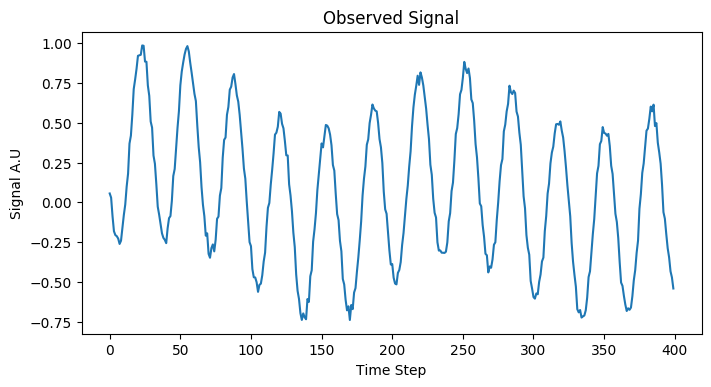

In [2]:
b_expected = np.array( [.20,.30, .60] )

S, C = get_signal(b_expected)
plt.figure(dpi = 100, figsize=(8,4))
plt.plot(S,'-')
plt.title('Observed Signal')
plt.xlabel('Time Step')
plt.ylabel('Signal A.U')
plt.savefig('fig01.png')

Also, I know that the signal above is a linear combination of three other signals:

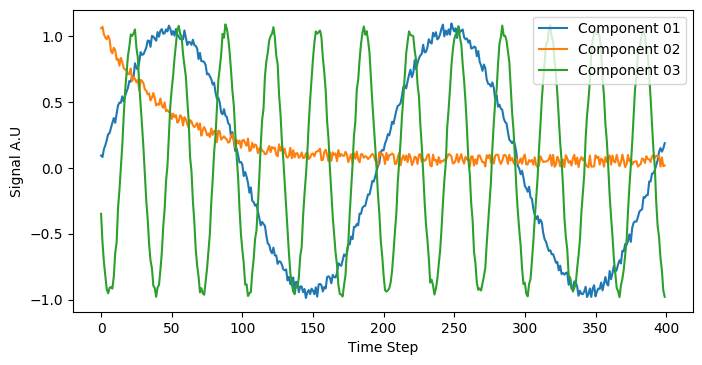

In [3]:
plt.figure(dpi = 100, figsize=(8,4))
plt.plot(C)
plt.legend(['Component 01','Component 02','Component 03'])
plt.xlabel('Time Step')
plt.ylabel('Signal A.U')
plt.savefig('fig02.png')

My task is to estimate how much each of the three components above contributes to the final signal. In other words, estimate the weightings for each component. This is a linear regression of the form:
![image.png](Eq01.png)

The way to solve this is to simply take the pseudo inverse of the matrix `C` (columns are equal to each component) by the vector `S`:  $$ w = C^{-1} S $$

In [4]:
# linear regression 
b_pred = linear_reg(C,S) 
print(b_pred,b_expected)

[0.2014579  0.27950773 0.59977421] [0.2 0.3 0.6]


I actually know the expected `b`; thus, i can estimate the error in my estimated `b`

In [5]:
error( b_pred, b_expected )

0.02054530404568321

As you can see above, the error in my estimate is quite good. But what if I reduce the temporal resolution of the data ?. For example, I can only sample every 2,5,8,10,20,20, and 30 steps. The code belows show how decreasing the temporal resolution (sampling less often) affects my estimate of `B`. It is clear that as I sample the data slower my estimate of B becomes less reliable.

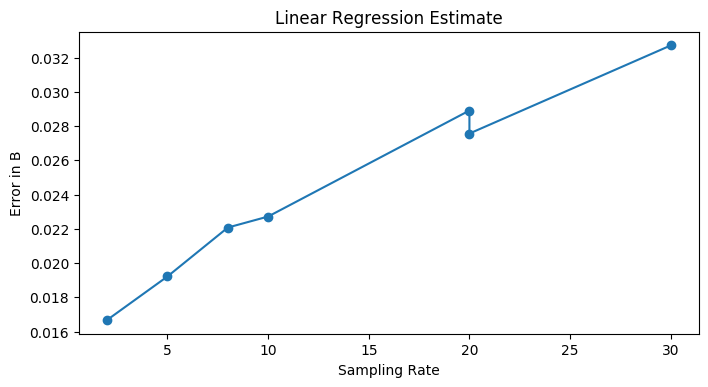

In [6]:
# effect of temporal resolution
# 100 samples at each temp res
step_size = [2,5,8,10,20,20,30]
error_in_b_lreg = []

for s in step_size:
    e=[]
    for i in range(1000):
        S, C = get_signal(b_expected)
        e.append(  error( linear_reg(C[0:-1:s,:], S[0:-1:s]), b_expected )) 

    
    error_in_b_lreg.append(np.array(e).mean())
    
    

plt.figure(dpi = 100, figsize=(8,4))  
plt.plot(step_size,error_in_b_lreg,'o-')
plt.xlabel('Sampling Rate');
plt.ylabel('Error in B');
plt.title('Linear Regression Estimate');

## - Low Rank models as a solution

A way of making the linear regression less sensitve to temporal resolution is the following:
- concatenate the matrices `C` ( size n x 3) and `T` (size n x 1) to create a new matix `A` of size n x 4
- estimate the decomposition of `A` into two matrices `X` (size n by k ) and `Y` (size k by 4)

![image.png](lrm2.png)

The rows of matrix `A` are associated with the temporal resolution of our data (one row per data points). While the columns of `A` are the four variables (3 components + 1 signal). On the other hand, the rows of `X` associated with temporal resolution, but the columns of `Y` the four variables projected onto a space that is independent of temporal resolution. The rows `Y` and columns of `X` are equal to `r`; the rank of the representation. In our case we know that k =3 because the fourth column is a linear combination of the first three columns.

If we assume that the relationship between the signal and components:

$$ s_i = w_1*c_i,_1 +  w_2*c_i,_2 +  w_3*c_i,_3 $$
$$ S = C * w  $$

Is also preserved for `Y` we could perform the regression between the first three columsn of `Y` and the fourtn column of `Y`:

$$ y_i,_4 = w_1*y_i,_1 + w_2*y_i,_2 +  w_3*y_i,_3 $$
$$ y_i,_4 = Y_{i, 1-4} * w = Z * w $$
$$ w = Z^{-1} * y_i,_4 *   $$

the code below shows how to do this in python

In [7]:
# regression by Low Rank at full temp rest
def low_rank_lrrm(c,t, K=3):
    A = np.append(c,t.reshape(-1,1),axis=1).copy()
    lrm = PCA(whiten=True,n_components=K).fit(A)
    Y_ = lrm.components_
    b_hat = np.linalg.pinv( Y_[:,0:3] ) @ Y_[:,-1]

    X_ = lrm.transform(A)
    
    return b_hat , X_, Y_


b_hat_lrm, _,_ = low_rank_lrrm(C,S)
error(b_expected, b_hat_lrm)

0.006313322433093227

We can now apply the same temporal res 

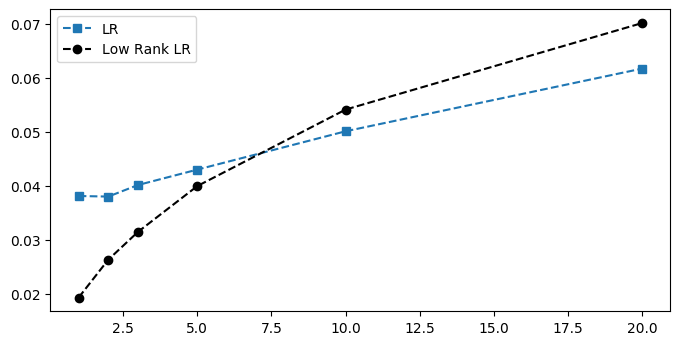

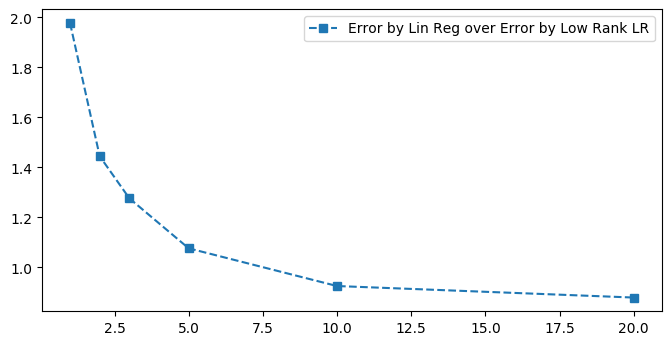

In [17]:
# effect of temporal resolution
error_low_rank = []
error_lreg = []
error_reco = []
step_size = [1,2,3,5,10,20]

for s in step_size:
    e1=[]
    e2=[]
    e3=[]
    
    for i in range(1000):
        
        S, C = get_signal(b_expected,.22)
        
        sig = S[0:-1:s]
        c   = C[0:-1:s,:]
        
        
        b, x_, y_ = low_rank_lrrm(c ,sig ,K=3)
        
        
        e1.append( error( b, b_expected )  ) 
        
        
        e2.append(  error( linear_reg(  c, sig), b_expected )) 
             

    error_low_rank.append(  np.array(e1).mean())
    error_lreg.append( np.array(e2).mean())

  
plt.figure(dpi = 100, figsize=(8,4))  
plt.plot(step_size, error_lreg,'s--')
plt.plot(step_size, error_low_rank,'o--k')
plt.legend(['LR','Low Rank LR'])

plt.figure(dpi = 100, figsize=(8,4))  
plt.plot(step_size, np.array(error_lreg) / np.array(error_low_rank),'s--')
plt.legend(['Error by Lin Reg over Error by Low Rank LR'])

As you can see the `low rank model` is able to estimate `W` better than standard linear regression

## NEXT

1. Apply idea to DCE MRI data